In [239]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [240]:
# Loads the California housing Dataset
housing = fetch_openml(name="house_prices", as_frame=True)  # noqa

In [241]:
data = pd.DataFrame(data= np.c_[housing['data'], housing['target']],
                     columns= housing['feature_names'] + ['target'])

In [242]:
liste_to_numeric = ['YrSold', 'YearBuilt', 'GrLivArea', 'LotFrontage', 'LotArea','GarageArea']
data[liste_to_numeric] = data[liste_to_numeric].apply(pd.to_numeric)

In [243]:
data.head()

Id MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1.0       60.0       RL         65.0   8450.0   Pave  None      Reg   
1  2.0       20.0       RL         80.0   9600.0   Pave  None      Reg   
2  3.0       60.0       RL         68.0  11250.0   Pave  None      IR1   
3  4.0       70.0       RL         60.0   9550.0   Pave  None      IR1   
4  5.0       60.0       RL         84.0  14260.0   Pave  None      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...      0.0   None  None        None     0.0    2.0   
1         Lvl    AllPub  ...      0.0   None  None        None     0.0    5.0   
2         Lvl    AllPub  ...      0.0   None  None        None     0.0    9.0   
3         Lvl    AllPub  ...      0.0   None  None        None     0.0    2.0   
4         Lvl    AllPub  ...      0.0   None  None        None     0.0   12.0   

   YrSold SaleType SaleCondition    target  
0  2008.0       WD        Normal  208500.0  
1  2007.0       WD        Normal  181500.0  
2  2008.0       WD        Normal  223500.0  
3  2006.0       WD       Abnorml  140000.0  
4  2008.0       WD        Normal  250000.0  

[5 rows x 81 columns]

# Data analysis

In [244]:
def dfInfo(df):
    return "This dataframe contains {} lines and {} columns".format(df.shape[0], df.shape[1])

dfInfo(data)

'This dataframe contains 1460 lines and 81 columns'

In [245]:
data.describe()

LotFrontage        LotArea    YearBuilt    GrLivArea   GarageArea  \
count  1201.000000    1460.000000  1460.000000  1460.000000  1460.000000   
mean     70.049958   10516.828082  1971.267808  1515.463699   472.980137   
std      24.284752    9981.264932    30.202904   525.480383   213.804841   
min      21.000000    1300.000000  1872.000000   334.000000     0.000000   
25%      59.000000    7553.500000  1954.000000  1129.500000   334.500000   
50%      69.000000    9478.500000  1973.000000  1464.000000   480.000000   
75%      80.000000   11601.500000  2000.000000  1776.750000   576.000000   
max     313.000000  215245.000000  2010.000000  5642.000000  1418.000000   

            YrSold  
count  1460.000000  
mean   2007.815753  
std       1.328095  
min    2006.000000  
25%    2007.000000  
50%    2008.000000  
75%    2009.000000  
max    2010.000000

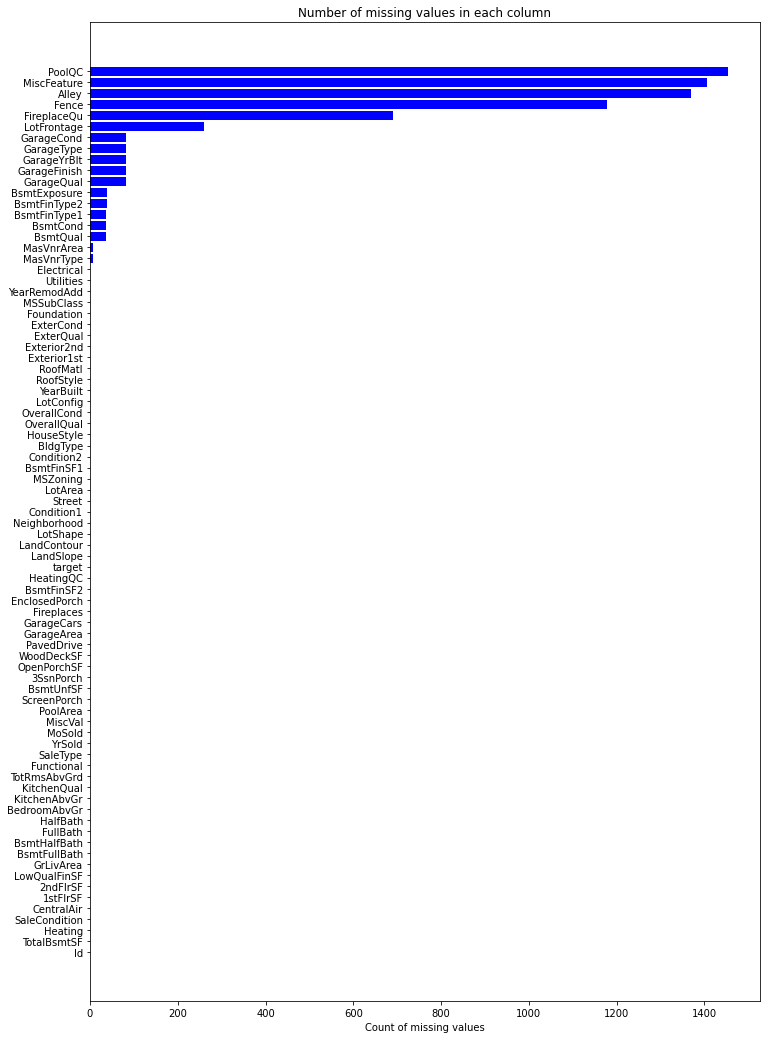

In [246]:
missing_df = data.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

In [247]:
dtype_df = data.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df
dtype_df.groupby("Column Type").aggregate('count').reset_index()

Column Type  Count
0     float64      6
1      object     75

In [248]:
data.dtypes

Id                object
MSSubClass        object
MSZoning          object
LotFrontage      float64
LotArea          float64
                  ...   
MoSold            object
YrSold           float64
SaleType          object
SaleCondition     object
target            object
Length: 81, dtype: object

Data cleaning

In [249]:
# create dumies
data['Fence'] = data['Fence'].notna()
data['Pool'] = data['PoolArea'] > 0

# create the new variable 'age'
data['Age'] = data.apply(lambda x: x['YrSold']-x['YearBuilt'] if (x['YearBuilt']<x['YearRemodAdd']) 
                                                           else (x['YrSold']-x['YearRemodAdd']), axis=1)

# Delete all data with MSZoning = commercial, agriculture and industrial as these are not residential units
data = data[(data.MSZoning != 'C (all)') & (data.MSZoning != 'I (all)') & (data.MSZoning != 'A (agr)')]

# Delete abnormal sales
data = data[(data.SaleCondition != 'Abnorml')] 
data = data[(data.SaleCondition != 'Family')] 


In [250]:
data['Fence'] = data['Fence'].replace({
    True: 1,
    False : 0
})
data['Pool'] = data['Pool'].replace({
    True: 1,
    False : 0
})

In [251]:
data['target'] = data['target'].apply(pd.to_numeric)

In [252]:
data['Pool'].dtypes

dtype('int64')

In [253]:
# Select Features
X = data[['Age','GrLivArea', 'LotFrontage', 'LotArea', 'GarageArea', 'Fence', 'Pool']]
Y = data[['target']]

In [254]:
X.to_csv('./data/intermediate/clean_X.csv', index=False)

In [255]:
X.head(50)

Age  GrLivArea  LotFrontage  LotArea  GarageArea  Fence  Pool
0    5.0     1710.0         65.0   8450.0       548.0      0     0
1   31.0     1262.0         80.0   9600.0       460.0      0     0
2    7.0     1786.0         68.0  11250.0       608.0      0     0
4    8.0     2198.0         84.0  14260.0       836.0      0     0
5   16.0     1362.0         85.0  14115.0       480.0      1     0
6    3.0     1694.0         75.0  10084.0       636.0      0     0
7   36.0     2090.0          NaN  10382.0       484.0      0     0
9   69.0     1077.0         50.0   7420.0       205.0      0     0
10  43.0     1040.0         70.0  11200.0       384.0      0     0
11   1.0     2324.0         85.0  11924.0       736.0      0     0
12  46.0      912.0          NaN  12968.0       352.0      0     0
13   1.0     1494.0         91.0  10652.0       840.0      0     0
14  48.0     1253.0          NaN  10920.0       352.0      1     0
15  78.0      854.0         51.0   6120.0       576.0      1     0
16  40.0     1004.0          NaN  11241.0       480.0      0     0
17  39.0     1296.0         72.0  10791.0       516.0      0     0
18   4.0     1114.0         66.0  13695.0       576.0      0     0
20   1.0     2376.0        101.0  14215.0       853.0      0     0
21  77.0     1108.0         57.0   7449.0       280.0      1     0
22   6.0     1795.0         75.0   9742.0       534.0      0     0
23  31.0     1060.0         44.0   4224.0       572.0      0     0
24  42.0     1060.0          NaN   8246.0       270.0      1     0
25   2.0     1600.0        110.0  14230.0       890.0      0     0
26  59.0      900.0         60.0   7200.0       576.0      0     0
27   3.0     1704.0         98.0  11478.0       772.0      0     0
28  49.0     1600.0         47.0  16321.0       319.0      0     0
29  81.0      520.0         60.0   6324.0       240.0      0     0
31  42.0     1228.0          NaN   8544.0       271.0      1     0
32   1.0     1234.0         85.0  11049.0       484.0      0     0
33  51.0     1700.0         70.0  10552.0       447.0      0     0
34   2.0     1561.0         60.0   7313.0       556.0      0     0
35   2.0     2452.0        108.0  13418.0       691.0      0     0
36  15.0     1097.0        112.0  10859.0       672.0      0     0
37  55.0     1297.0         74.0   8532.0       498.0      0     0
39  53.0     1152.0         65.0   6040.0         0.0      0     0
41  48.0     1328.0        115.0  16905.0       308.0      0     0
42  24.0      884.0          NaN   9180.0       504.0      1     0
43  33.0      938.0          NaN   9200.0       308.0      1     0
44  47.0     1150.0         70.0   7945.0       300.0      0     0
45   5.0     1752.0         61.0   7658.0       576.0      0     0
47   1.0     1656.0         84.0  11096.0       826.0      0     0
48  89.0     1452.0         33.0   4456.0         0.0      0     0
49  41.0      955.0         66.0   7742.0       386.0      1     0
50  10.0     1470.0          NaN  13869.0       388.0      0     0
51  72.0     1176.0         52.0   6240.0       528.0      1     0
52  47.0      816.0        110.0   8472.0       516.0      0     0
53  25.0     1842.0         68.0  50271.0       894.0      0     0
54  52.0     1360.0         60.0   7134.0       572.0      1     0
55  44.0     1425.0        100.0  10175.0       576.0      0     0
57   2.0     1720.0         89.0  11645.0       565.0      0     0

In [256]:
X.isnull().sum()

Age              0
GrLivArea        0
LotFrontage    240
LotArea          0
GarageArea       0
Fence            0
Pool             0
dtype: int64

In [257]:
X = X.fillna(X['LotFrontage'].mean())

In [258]:
X.isnull().sum()

Age            0
GrLivArea      0
LotFrontage    0
LotArea        0
GarageArea     0
Fence          0
Pool           0
dtype: int64

In [259]:
X.to_csv('./data/intermediate/clean_X.csv', index=False)

In [260]:
X.shape

(1334, 7)

In [261]:
Y.head()

target
0  208500.0
1  181500.0
2  223500.0
4  250000.0
5  143000.0

In [262]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=.2, random_state=1121218)

In [263]:
numerical_features = X_train.select_dtypes(include='number').columns.tolist()
categorical_features = X_train.select_dtypes(exclude='number').columns.tolist()

In [264]:
print(numerical_features)

['Age', 'GrLivArea', 'LotFrontage', 'LotArea', 'GarageArea', 'Fence', 'Pool']


In [265]:
print(categorical_features)

[]


In [266]:
numeric_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', MinMaxScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

In [267]:
from sklearn.compose import ColumnTransformer

full_processor = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, numerical_features),
    ('category', categorical_pipeline, categorical_features)
])

In [268]:
randomf = RandomForestRegressor()

randomf_pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', randomf)
])

In [269]:
from sklearn.model_selection import GridSearchCV

param_dict = {'model__n_estimators': [50,100,150,200], 'model__bootstrap': [True,False]}

search = GridSearchCV(randomf_pipeline, param_dict, 
                      cv=10, 
                      scoring='neg_mean_absolute_error')

_ = search.fit(X_train, y_train)

print('Best score:', abs(search.best_score_))

print('Best params:', search.best_params_)

Best score: 24552.39480902629
Best params: {'model__bootstrap': True, 'model__n_estimators': 200}


In [270]:
print(search.best_estimator_.steps[1][1].feature_importances_)

[0.24349687 0.38292102 0.04794813 0.07056994 0.25210853 0.00185594
 0.00109957]


In [271]:
import pickle
filename = './model/finalized_model.sav'
pickle.dump(search, open(filename, 'wb'))

In [272]:
from sklearn import metrics

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('__________________________________')

In [273]:
test_pred = search.predict(X_valid)
train_pred = search.predict(X_train)


In [274]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_valid, test_pred)

print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 20111.09019975031
MSE: 859342065.6846256
RMSE: 29314.536763944023
R2 Square 0.8273393423263044
__________________________________
Train set evaluation:
_____________________________________
MAE: 8945.604449167671
MSE: 210537038.39089632
RMSE: 14509.894499647347
R2 Square 0.967603818099149
__________________________________


In [275]:
y_pred = search.predict(X_valid)
y_pred = pd.DataFrame(y_pred)
y_pred.head()

0
0  121672.750000
1  147919.833333
2  151637.826667
3  131320.165000
4   98341.000000

In [276]:
print('Mean absolute error : ', mean_absolute_error(y_valid, y_pred))

Mean absolute error :  20111.09019975031


In [277]:
data['target'].dtypes

dtype('float64')

In [278]:
xgb_model = XGBRegressor()

xgb_pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', xgb_model)
])

In [279]:
from sklearn.model_selection import GridSearchCV

# A parameter grid for XGBoost
params_dict = { 'model__max_depth': [2, 4, 6],
           'model__n_estimators': [100, 500, 1000]}

search = GridSearchCV(xgb_pipeline, params_dict ,cv=5, scoring='neg_mean_absolute_error')

_ = search.fit(X_train, y_train)

print('Best score:', abs(search.best_score_))

print('Best params:', search.best_params_)

Best score: 26016.231551585603
Best params: {'model__max_depth': 4, 'model__n_estimators': 100}


In [280]:
test_pred = search.predict(X_valid)
train_pred = search.predict(X_train)

In [281]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_valid, test_pred)

print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 20285.681004213482
MSE: 860275130.2183883
RMSE: 29330.447153399968
R2 Square 0.8271518692088059
__________________________________
Train set evaluation:
_____________________________________
MAE: 8770.766393802718
MSE: 140454424.20553553
RMSE: 11851.346936341688
R2 Square 0.9783877121568811
__________________________________


In [282]:
from sklearn.linear_model import Lasso
ridge_model = Lasso(normalize=True)

ridge_pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', xgb_model)
])

In [283]:
from sklearn.model_selection import GridSearchCV

# A parameter grid for XGBoost
params_dict = { "model__alpha":[0.1, 0.5, 1, 5, 50, 100]}

search = GridSearchCV(ridge_pipeline, params_dict ,cv=5, scoring='r2')

_ = search.fit(X_train, y_train)

print('Best score:', abs(search.best_score_))

print('Best params:', search.best_params_)

Best score: 0.7368642663936551
Best params: {'model__alpha': 100}


In [284]:
test_pred = search.predict(X_valid)
train_pred = search.predict(X_train)

In [285]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_valid, test_pred)

print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 20025.43036048689
MSE: 886901790.2596532
RMSE: 29780.89639785299
R2 Square 0.8218019895532394
__________________________________
Train set evaluation:
_____________________________________
MAE: 2549.6846957005623
MSE: 13110504.385667024
RMSE: 3620.8430490242217
R2 Square 0.9979826338959827
__________________________________


In [286]:
from keras.models import Sequential
from keras.layers import Dense ,Dropout,BatchNormalization
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

In [287]:
# define base model
def baseline_model():
    # create model
    model = Sequential()
    
    model.add(Dense(16, input_dim=7, activation='relu'))
    
    model.add(Dense(8, input_dim=7, activation='relu'))
    
    model.add(Dense(1))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [288]:
estimator = KerasRegressor(build_fn=baseline_model, epochs=30, batch_size=3, verbose=1)

C:\Users\Apprenant\AppData\Local\Temp\ipykernel_9856\3838108994.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasRegressor(build_fn=baseline_model, epochs=30, batch_size=3, verbose=1)


In [289]:
history=estimator.fit(X_train,y_train)

Epoch 1/30
356/356 [==============================] - 1s 1ms/step - loss: 36830707712.0000
Epoch 2/30
356/356 [==============================] - 0s 1ms/step - loss: 21331968000.0000
Epoch 3/30
356/356 [==============================] - 0s 1ms/step - loss: 18123870208.0000
Epoch 4/30
356/356 [==============================] - 0s 1ms/step - loss: 16394445824.0000
Epoch 5/30
356/356 [==============================] - 0s 1ms/step - loss: 15540818944.0000
Epoch 6/30
356/356 [==============================] - 0s 1ms/step - loss: 14813196288.0000
Epoch 7/30
356/356 [==============================] - 0s 1ms/step - loss: 14078082048.0000
Epoch 8/30
356/356 [==============================] - 0s 1ms/step - loss: 13413581824.0000
Epoch 9/30
356/356 [==============================] - 0s 1ms/step - loss: 12721225728.0000
Epoch 10/30
356/356 [==============================] - 0s 1ms/step - loss: 12070053888.0000
Epoch 11/30
356/356 [==============================] - 0s 1ms/step - loss: 11412471808.00

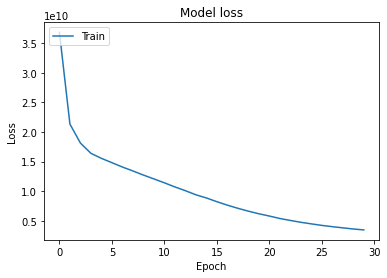

In [290]:
# Plot training & validation loss values
plt.plot(history.history['loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [291]:
test_pred = estimator.predict(X_valid)
train_pred = estimator.predict(X_train)

356/356 [==============================] - 0s 1ms/step


In [292]:
y_valid

target
498   130000.0
690   141000.0
200   140000.0
484   132500.0
146   105000.0
...        ...
946   143000.0
451   280000.0
1033  230000.0
1365  216000.0
340   202900.0

[267 rows x 1 columns]

In [293]:
test_pred

array([111836.984, 109919.68 , 142557.77 , 117133.81 ,  96084.22 ,
       210672.33 , 155498.48 , 185463.44 , 211990.98 , 219054.77 ,
       227730.39 , 117381.58 ,  93817.16 , 220895.25 , 227628.75 ,
       249836.67 , 172201.02 , 161229.73 , 274059.94 , 215574.11 ,
       105246.72 , 206900.08 , 137175.53 ,  83289.   , 133801.3  ,
       210327.08 , 111975.984, 293928.47 ,  51024.35 , 210817.92 ,
       199790.61 ,  94693.875, 137303.14 , 195861.77 , 208101.81 ,
       203062.89 , 131048.45 , 179284.98 , 233411.33 , 267816.38 ,
       124542.78 , 238075.64 , 124047.79 , 144405.83 , 266528.3  ,
       189555.69 , 207531.14 , 214299.23 , 171123.61 , 163626.94 ,
       165187.61 , 155020.69 ,  72862.92 , 165295.73 , 137512.52 ,
       190487.92 , 152798.69 , 213165.98 , 200627.98 , 190448.95 ,
       269989.47 , 128587.234, 134040.64 , 100489.664, 151901.3  ,
       120149.2  , 174522.05 , 159788.4  , 136626.84 , 125245.46 ,
       184105.27 , 223820.83 , 150582.4  , 175083.48 , 217906.

In [294]:
train_error =  np.abs(y_valid - test_pred)
mean_error = np.mean(train_error)
min_error = np.min(train_error)
max_error = np.max(train_error)
std_error = np.std(train_error)

ValueError: Unable to coerce to Series, length must be 1: given 267

In [ ]:
print("std_error: ",std_error)
print("mean_error: ",mean_error)
print("min_error: ",min_error)
print("max_error: ",max_error)

std_error:  422876633.97204506
mean_error:  862973027.6329588
min_error:  185411803.0
max_error:  4989995532.0


In [ ]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_valid, test_pred)

print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 28842.870172050563
MSE: 1727372230.5673206
RMSE: 41561.66780300473
R2 Square 0.6529330550815975
__________________________________
Train set evaluation:
_____________________________________
MAE: 32592.837226159794
MSE: 2599686821.467692
RMSE: 50987.124075277
R2 Square 0.5999757202001456
__________________________________
